# Import Libraries & Create Pre-Processing Class

In [110]:
import optuna
from xgboost.sklearn import XGBClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import brier_score_loss, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [111]:
import warnings
warnings.filterwarnings("ignore")

In [371]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping

In [112]:
!pip install category_encoders
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy import stats as st
import category_encoders as ce
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, brier_score_loss, confusion_matrix, accuracy_score
#----------------------CategoricalTransformer----------------------

class CategoricalTransformer():
    def __init__(self, max_unique_values = 20):
        self.max_unique_values = max_unique_values
        self.__selected_features = None

    def fit(self, X):
        # Identify features with 20 or fewer unique values
        self.__selected_features = X.columns[X.nunique() <= self.max_unique_values]
        return self

    def transform(self, X):
        X_transformed = X.copy()
        # Convert selected features to categorical
        X_transformed[self.__selected_features] = X_transformed[self.__selected_features].astype('object')
        return X_transformed
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



#----------------------MissingValuesFiller----------------------

class MissingValuesFiller():
    def __init__(self, numeric_strategy='mean', categorical_strategy='most_frequent'):
        self.numeric_strategy = numeric_strategy
        self.categorical_strategy = categorical_strategy
        self.__numeric_cols = None
        self.__categorical_cols = None
        self.__mean_numeric_series = None
        self.__mode_categorical_series = None

    def fit(self, X):
        # Separate numeric and categorical columns
        self.__numeric_cols = X.select_dtypes(include='number').columns
        self.__categorical_cols = X.select_dtypes(include='object').columns
        self.__mean_numeric_series= X[self.__numeric_cols].agg(self.numeric_strategy)
        self.__mode_categorical_series= X[self.__categorical_cols].mode().iloc[0] if self.categorical_strategy  == 'most_frequent' else self.categorical_strategy

    def transform(self, X):
        X_transformed = X.copy()
         # Fill missing values in numeric columns
        X_transformed[self.__numeric_cols] = X[self.__numeric_cols].fillna(self.__mean_numeric_series)

        # Fill missing values in categorical columns
        X_transformed[self.__categorical_cols] = X[self.__categorical_cols].fillna(self.__mode_categorical_series)

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)



#----------------------DropHighCorrelationFeatures----------------------


class DropHighCorrelationFeatures():
    def __init__(self, threshold = 0.85):
        self.threshold = threshold
        self.to_drop_cols = None

    def fit(self, X):
        # Calculate the correlation matrix
        correlation_matrix = X.corr().abs()

        # Create a mask to identify highly correlated features
        upper_triangle_mask = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

        # Identify features with correlation above the threshold
        to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > self.threshold)]

        self.to_drop_cols = to_drop



    def transform(self, X):
        X_transformed = X.copy()

        # Drop highly correlated features
        X_transformed = X_transformed.drop(columns=self.to_drop_cols)

        return X_transformed
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

#----------------------SplitterByType----------------------

class SplitterByType():
    def __init__(self):
        self.__numeric_cols = None
        self.__categorical_cols = None

    def fit(self, X):
        # Identify numeric and categorical columns
        self.__numeric_cols = X.select_dtypes(include='number').columns
        self.__categorical_cols = X.select_dtypes(include='object').columns



    def transform(self, X):
        X_transformed = X.copy()

        # Create DataFrames based on column types
        numeric_df = X[self.__numeric_cols].copy()
        categorical_df = X[self.__categorical_cols].copy()

        return numeric_df, categorical_df

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


#----------------------ConstantsAndHighCardinalityDropper----------------------
class ConstantsAndHighCardinalityDropper():
    def __init__(self,max_unique_values=2000):
        self.max_unique_values = max_unique_values
        self.__non_constant_cols = None
        self.__high_cardinality_cols = None

    def fit(self, X):
        # Identify numeric and categorical columns
        self.__non_constant_cols = X.columns[X.nunique() > 1]
        self.__high_cardinality_cols = X.columns[X.nunique() > self.max_unique_values]


    def transform(self, X):
        X_transformed = X.copy()

        # Get non constants columns
        X_transformed = X_transformed[self.__non_constant_cols]

        #drop high cardinality columns
        X_transformed = X_transformed.drop(columns=self.__high_cardinality_cols)

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)


#----------------------ConstantsAndHighCardinalityDropper----------------------
class FrequencyEncoder():
    def __init__(self):
        self.categorical_features = None
        #dictionary with values of the categorical features as keys and dictionary of frequencies
        self.mapper = {}

    def fit(self, X):
        # Identify numeric and categorical columns
        self.categorical_features = X.select_dtypes('object').columns

        for cat_col in self.categorical_features:
            class_values_frequency = {}
            for class_value in X[cat_col].unique():
                class_values_frequency[class_value] = sum(X[cat_col]==class_value)/X.shape[0]
            self.mapper[cat_col] = class_values_frequency


    def transform(self, X):
        X_transformed = X.copy()

        # apply frequencies mapping
        for cat_col in self.categorical_features:
            X_transformed[cat_col] = X_transformed[cat_col].map(self.mapper[cat_col])

        return X_transformed

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [113]:
df = pd.read_csv('../data/raw/training.csv')
X = df.iloc[:,:-1].copy()
y = df.Target
X_val1 = pd.read_csv('../data/raw/data_validation3.csv')

# Implementation

In [114]:
def preprocess_data(X: pd.DataFrame, X_val: pd.DataFrame, numeric_strategy='mean',categorical_strategy='most_frequent',
                   threshold=0.85,cat_transformer_max_unique_values = 20,cardinality_max_unique_values=2000,
                   n_components = 40, cat_encoder_strategy = 'woee'):
    # Step 0: Copy Values to transform
    X_transformed = X.copy()
    X_val_transformed = X_val.copy()

    # Step 1: Fill missing values
    filler = MissingValuesFiller(numeric_strategy=numeric_strategy, categorical_strategy=categorical_strategy)
    X_transformed = filler.fit_transform(X_transformed)
    X_val_transformed = filler.transform(X_val_transformed)

    # Step 2: Reduce dimensionality due to high correlation
    correlation_reducer = DropHighCorrelationFeatures(threshold=threshold)
    X_transformed = correlation_reducer.fit_transform(X_transformed)
    X_val_transformed = correlation_reducer.transform(X_val_transformed)

    # Step 3: Convert features to categorical
    categorical_transformer = CategoricalTransformer(max_unique_values = cat_transformer_max_unique_values).fit(X_transformed)
    X_transformed = categorical_transformer.transform(X_transformed)
    X_val_transformed = categorical_transformer.transform(X_val_transformed)


    # Step 4: Drop constants and high-cardinality features
    dropper = ConstantsAndHighCardinalityDropper(max_unique_values = cardinality_max_unique_values)
    X_transformed = dropper.fit_transform(X_transformed)
    X_val_transformed = dropper.transform(X_val_transformed)


    # Step 5: Split the DataFrame into numeric and categorical parts
    splitter = SplitterByType()
    X_transformed_numeric, X_transformed_categorical = splitter.fit_transform(X_transformed)
    X_val_transformed_numeric, X_val_transformed_categorical = splitter.transform(X_val_transformed)
    incosistencias_columns = ['Feature_11', 'Feature_71', 'Feature_88', 'Feature_90',
       'Feature_143', 'Feature_156', 'Feature_176', 'Feature_194',
       'Feature_200', 'Feature_216', 'Feature_237', 'Feature_268',
       'Feature_273', 'Feature_319', 'Feature_339', 'Feature_386',
       'Feature_391', 'Feature_402', 'Feature_407', 'Feature_410',
       'Feature_417', 'Feature_421', 'Feature_422', 'Feature_427',
       'Feature_431', 'Feature_441', 'Feature_471', 'Feature_477',
       'Feature_492', 'Feature_532']
    col_new = set(X_transformed_numeric.columns)-set(incosistencias_columns)
    X_transformed_numeric = X_transformed_numeric[col_new]
    X_val_transformed_numeric = X_val_transformed_numeric[col_new]

    # Step 6: Reduce dimensionality of numeric features
    pca = PCA(n_components)
#     X_transformed_numeric = pd.DataFrame(pca.fit_transform(X_transformed_numeric))
#     X_val_transformed_numeric = pd.DataFrame(pca.transform(X_val_transformed_numeric))
#     print(f'Explained Variance with {n_components} components: {pca.explained_variance_ratio_.sum()}')

    # Step 7: Categorical Encoding
    if cat_encoder_strategy == 'woee':
        # Step 7.1 (Optional): Apply WOE Encoding
        X_columns = X_transformed_categorical.columns
        woe_encoder = ce.WOEEncoder(cols=X_columns)

        X_transformed_categorical = woe_encoder.fit_transform(X_transformed_categorical, y)
        X_val_transformed_categorical = woe_encoder.transform(X_val_transformed_categorical)
    elif cat_encoder_strategy == 'freq':
        # Step 7.2 (Optional): Apply self defined Frequency Encoding
        X_columns = X_transformed_categorical.columns
        freq_encoder = FrequencyEncoder()

        X_transformed_categorical = freq_encoder.fit_transform(X_transformed_categorical)
        X_val_transformed_categorical = freq_encoder.transform(X_val_transformed_categorical)
    else:
        # Step 7.3 (Optional): Apply One Hot Encoding
        X_columns = X_transformed_categorical.columns
        ohe_encoder = ce.OneHotEncoder()

        X_transformed_categorical = ohe_encoder.fit_transform(X_transformed_categorical)
        X_val_transformed_categorical = ohe_encoder.transform(X_val_transformed_categorical)

    # Step 8: Mixing steps 6 & 7 to prepare data for modelling
    X_transformed = pd.concat([X_transformed_numeric,X_transformed_categorical], axis=1)
    X_val_transformed = pd.concat([X_val_transformed_numeric,X_val_transformed_categorical], axis=1)

    return X_transformed, X_val_transformed

**Next steps... concatenate dataframes applying encoders to categorical data**

In [473]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
X_transformed, X_val_transformed = preprocess_data(X_train, X_test, cat_encoder_strategy='ohe')

# AutoEncoder

In [474]:
X_train = X_transformed.copy()
X_test = X_val_transformed.copy()

In [475]:
# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.9, random_state=42)
# X_train, X_test, y_train, y_test = X, X_val, Y, []

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

In [476]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2306, 1292), (257, 1292), (2306,), (257,))

In [486]:
    # this is the size of our encoded representations

    encoding_dim = 1000

    # this is our input placeholder
    input_data = Input(shape=(X_train.shape[1],))
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation="relu")(input_data)
    encoded = Dense(700, activation="relu")(encoded)
    encoded = Dense(500, activation="relu")(encoded)
    encoded = Dense(200, activation="relu")(encoded)
    encoded = Dense(150, activation="relu")(encoded)
    encoded = Dense(100, activation="relu")(encoded)
    # encoded = Dense(15, activation="relu")(encoded)
    encoded = Dense(50, activation="relu")(encoded)

    # "decoded" is the lossy reconstruction of the input

    # decoded = Dense(15, activation="relu")(encoded)
    decoded = Dense(100, activation="relu")(encoded)
    decoded = Dense(150, activation="relu")(decoded)
    decoded = Dense(200, activation="relu")(decoded)
    decoded = Dense(500, activation="relu")(decoded)
    decoded = Dense(700, activation="relu")(decoded)
    decoded = Dense(encoding_dim, activation="relu")(decoded)
    decoded = Dense(X_train.shape[1], activation="sigmoid")(decoded)

In [487]:
X_train.shape, X_test.shape

((2306, 1292), (257, 1292))

In [488]:
# Explit the autoencoder to get the encoder only
# encoder = Model(input_layer, autoencoder.layers[6].output)
# encoder.summary()

# Encode the train data
encoded_train = encoder.predict(X_train)

# Encode the test data
encoded_test = encoder.predict(X_test)


9/9 [==============================] - 0s 3ms/step


In [489]:
encoded_train.shape, y_train.shape

((2306, 50), (2306,))

# Modelling

In [490]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, brier_score_loss
from imblearn.over_sampling import SMOTE


In [491]:
import pickle


In [492]:
encoded_train.shape

(2306, 50)

In [493]:
# Define la función objetivo para la optimización de hiperparámetros
def objective(trial):
    # Define los hiperparámetros que se optimizarán
    param = {
        "verbose": 1,
        "seed":19970808,
        "objective":"binary:logistic",
        "learning_rate":trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [5,20,50,100]),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    # Crea un modelo de regresión logística con los hiperparámetros definidos
    xgb_model = XGBClassifier(**param)
    steps = [('over', SMOTE(sampling_strategy='minority', random_state=42)), ('model', xgb_model)]
    # steps = [('model', xgb_model)]
    pipeline = Pipeline(steps=steps)
    pipeline.fit(encoded_train, y_train)
    predictions = pipeline.predict_proba(encoded_test)[:,-1]
    brier_score = brier_score_loss(y_test, predictions)
    if brier_score<0.010:
        print("../models_encoder/{}.pickle".format(trial.number))
        with open("../models_encoder/{}.pickle".format(trial.number), "wb") as fout:
             pickle.dump(pipeline, fout)
    # Realiza validación cruzada para evaluar el modelo
#     score = cross_val_score(
#     pipeline,
#     encoded_train,
#     y_train,
#     scoring=make_scorer(brier_score_loss, needs_proba=True),
#     cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
#     )

    return brier_score

In [494]:
# Crea un objeto de estudio de Optuna para la optimización
study = optuna.create_study(direction="minimize")

# Realiza la optimización de hiperparámetros con un número limitado de iteraciones y tiempo máximo
study.optimize(objective, n_trials=300,
    timeout=600,
    show_progress_bar=False)

# Imprime información sobre los resultados de la optimización
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-12-17 23:39:40,528] A new study created in memory with name: no-name-e056f1ae-4416-42cc-9b5f-3c74cceed56d
[I 2023-12-17 23:39:40,682] Trial 0 finished with value: 0.18357178938854807 and parameters: {'lambda': 0.10361265831817038, 'n_estimators': 50, 'max_depth': 10, 'alpha': 0.00157792978987944, 'subsample': 0.2655713966980904, 'colsample_bytree': 0.996746874775476}. Best is trial 0 with value: 0.18357178938854807.
[I 2023-12-17 23:39:40,728] Trial 1 finished with value: 0.21417992158689264 and parameters: {'lambda': 0.4152756274683868, 'n_estimators': 5, 'max_depth': 9, 'alpha': 7.411017763082618e-05, 'subsample': 0.428450812358759, 'colsample_bytree': 0.9696400958249476}. Best is trial 0 with value: 0.18357178938854807.
[I 2023-12-17 23:39:40,794] Trial 2 finished with value: 0.24999860942108035 and parameters: {'lambda': 1.0777743625434674e-06, 'n_estimators': 50, 'max_depth': 5, 'alpha': 0.00013743268398732248, 'subsample': 0.44427385278789755, 'colsample_bytree': 0.785174

[I 2023-12-17 23:39:44,636] Trial 26 finished with value: 0.15259549934818392 and parameters: {'lambda': 0.18579708798316436, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.00047312231813239936, 'subsample': 0.5441131520217906, 'colsample_bytree': 0.45714696737074123}. Best is trial 26 with value: 0.15259549934818392.
[I 2023-12-17 23:39:44,719] Trial 27 finished with value: 0.2499999679944054 and parameters: {'lambda': 1.1544741090573129e-07, 'n_estimators': 5, 'max_depth': 9, 'alpha': 0.0003240508785011433, 'subsample': 0.6684042396427148, 'colsample_bytree': 0.44649848577459117}. Best is trial 26 with value: 0.15259549934818392.
[I 2023-12-17 23:39:44,800] Trial 28 finished with value: 0.2425505652013502 and parameters: {'lambda': 0.010406406623412611, 'n_estimators': 20, 'max_depth': 7, 'alpha': 0.0007577975083972011, 'subsample': 0.5165781493725595, 'colsample_bytree': 0.3169948166702807}. Best is trial 26 with value: 0.15259549934818392.
[I 2023-12-17 23:39:44,978] Trial 29 fin

[I 2023-12-17 23:39:49,540] Trial 52 finished with value: 0.17582109051588424 and parameters: {'lambda': 0.5227704341419366, 'n_estimators': 100, 'max_depth': 9, 'alpha': 0.07191428136307991, 'subsample': 0.6286374995760251, 'colsample_bytree': 0.5012139364170808}. Best is trial 45 with value: 0.15130580670987262.
[I 2023-12-17 23:39:49,620] Trial 53 finished with value: 0.2459091018543173 and parameters: {'lambda': 0.1269810393322465, 'n_estimators': 100, 'max_depth': 1, 'alpha': 6.250607489183096e-05, 'subsample': 0.5367034290406845, 'colsample_bytree': 0.4152513833327647}. Best is trial 45 with value: 0.15130580670987262.
[I 2023-12-17 23:39:49,868] Trial 54 finished with value: 0.15726272786414244 and parameters: {'lambda': 0.06887192850393829, 'n_estimators': 100, 'max_depth': 9, 'alpha': 0.007019352946013816, 'subsample': 0.5866079626057497, 'colsample_bytree': 0.543861882765806}. Best is trial 45 with value: 0.15130580670987262.
[I 2023-12-17 23:39:50,133] Trial 55 finished with

[I 2023-12-17 23:39:55,314] Trial 78 finished with value: 0.18363911234700495 and parameters: {'lambda': 0.021180342315591492, 'n_estimators': 100, 'max_depth': 10, 'alpha': 7.425826988920218e-07, 'subsample': 0.5086690856119318, 'colsample_bytree': 0.5283247732962101}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:39:55,568] Trial 79 finished with value: 0.16484115990505185 and parameters: {'lambda': 0.061745940834743655, 'n_estimators': 100, 'max_depth': 9, 'alpha': 0.00010315947128759508, 'subsample': 0.43205909609407456, 'colsample_bytree': 0.4581493048891768}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:39:55,693] Trial 80 finished with value: 0.2247110135615614 and parameters: {'lambda': 0.12697680038685755, 'n_estimators': 100, 'max_depth': 2, 'alpha': 1.6741695151566933e-06, 'subsample': 0.7196897920353187, 'colsample_bytree': 0.6401705917511114}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:39:56,026] Trial 81 f

[I 2023-12-17 23:40:01,659] Trial 104 finished with value: 0.16337505690408868 and parameters: {'lambda': 0.1624097657322554, 'n_estimators': 100, 'max_depth': 10, 'alpha': 1.318539530380577e-05, 'subsample': 0.5717821753543463, 'colsample_bytree': 0.867964417407469}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:01,941] Trial 105 finished with value: 0.1516118146231631 and parameters: {'lambda': 0.07529210987593404, 'n_estimators': 100, 'max_depth': 10, 'alpha': 4.704456191023482e-06, 'subsample': 0.49047760435715304, 'colsample_bytree': 0.6435698735576424}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:02,212] Trial 106 finished with value: 0.15899492495817732 and parameters: {'lambda': 0.0666435675024113, 'n_estimators': 100, 'max_depth': 10, 'alpha': 9.135514682374714e-06, 'subsample': 0.491221979353592, 'colsample_bytree': 0.7070682010302666}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:02,583] Trial 107 fin

[I 2023-12-17 23:40:08,613] Trial 130 finished with value: 0.16672522430825992 and parameters: {'lambda': 0.5273334072180355, 'n_estimators': 100, 'max_depth': 10, 'alpha': 2.9297023385753737e-06, 'subsample': 0.6684039118162299, 'colsample_bytree': 0.5986314636286308}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:08,892] Trial 131 finished with value: 0.15108590504037583 and parameters: {'lambda': 0.13404259734163962, 'n_estimators': 100, 'max_depth': 10, 'alpha': 1.8952415903608107e-05, 'subsample': 0.5013560499541467, 'colsample_bytree': 0.6728178102215463}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:09,177] Trial 132 finished with value: 0.15110891254927517 and parameters: {'lambda': 0.11035924321280084, 'n_estimators': 100, 'max_depth': 10, 'alpha': 1.9339544330302138e-05, 'subsample': 0.5030257631594786, 'colsample_bytree': 0.4882205831620997}. Best is trial 73 with value: 0.14861812009000933.
[I 2023-12-17 23:40:09,488] Trial 1

[I 2023-12-17 23:40:15,558] Trial 156 finished with value: 0.16359094602938065 and parameters: {'lambda': 0.16722062145954952, 'n_estimators': 100, 'max_depth': 10, 'alpha': 1.0852893786953853e-07, 'subsample': 0.4266406623992286, 'colsample_bytree': 0.564150512878072}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:15,838] Trial 157 finished with value: 0.15502658200842637 and parameters: {'lambda': 0.25714883344024375, 'n_estimators': 100, 'max_depth': 10, 'alpha': 3.349162085116808e-07, 'subsample': 0.4428735615926115, 'colsample_bytree': 0.5283836791559972}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:16,113] Trial 158 finished with value: 0.14925668612847193 and parameters: {'lambda': 0.11956133898483588, 'n_estimators': 100, 'max_depth': 10, 'alpha': 2.839408172557773e-07, 'subsample': 0.47907610642259135, 'colsample_bytree': 0.5203719416088592}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:16,411] Trial

[I 2023-12-17 23:40:22,261] Trial 182 finished with value: 0.15397031669102829 and parameters: {'lambda': 0.10820256542245892, 'n_estimators': 100, 'max_depth': 10, 'alpha': 1.2789928811492521e-06, 'subsample': 0.5073186653852989, 'colsample_bytree': 0.5269482640131296}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:22,571] Trial 183 finished with value: 0.15930587265826618 and parameters: {'lambda': 0.167443740535258, 'n_estimators': 100, 'max_depth': 10, 'alpha': 3.072240058759729e-06, 'subsample': 0.4750157673052554, 'colsample_bytree': 0.5549862582146099}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:22,839] Trial 184 finished with value: 0.16806945351827404 and parameters: {'lambda': 0.2713167374215568, 'n_estimators': 100, 'max_depth': 10, 'alpha': 7.962531998422197e-07, 'subsample': 0.5160178178500822, 'colsample_bytree': 0.5896845513536172}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:23,124] Trial 18

[I 2023-12-17 23:40:29,519] Trial 208 finished with value: 0.16340923781424715 and parameters: {'lambda': 0.16271050098472845, 'n_estimators': 100, 'max_depth': 10, 'alpha': 5.1649728808854216e-05, 'subsample': 0.48612330203298815, 'colsample_bytree': 0.5170096229154914}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:29,669] Trial 209 finished with value: 0.1607782528650873 and parameters: {'lambda': 0.22060095199961852, 'n_estimators': 50, 'max_depth': 9, 'alpha': 2.7295680462159884e-05, 'subsample': 0.5285825321081101, 'colsample_bytree': 0.5267280066255259}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:29,942] Trial 210 finished with value: 0.14967530364266182 and parameters: {'lambda': 0.1287887461703333, 'n_estimators': 100, 'max_depth': 10, 'alpha': 6.99805137669595e-05, 'subsample': 0.5017886586339784, 'colsample_bytree': 0.6738220300487808}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:30,214] Trial 21

[I 2023-12-17 23:40:36,458] Trial 234 finished with value: 0.15159858779931612 and parameters: {'lambda': 0.09753725893712403, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.00016441548039180075, 'subsample': 0.4996513812520804, 'colsample_bytree': 0.6538850262322278}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:36,734] Trial 235 finished with value: 0.15169857831028033 and parameters: {'lambda': 0.2011901068711048, 'n_estimators': 100, 'max_depth': 10, 'alpha': 4.4792036901199945e-05, 'subsample': 0.524198568839399, 'colsample_bytree': 0.6583637752411794}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:37,018] Trial 236 finished with value: 0.15049794023952437 and parameters: {'lambda': 0.10840222027167698, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.00019433967337692795, 'subsample': 0.4987612706746434, 'colsample_bytree': 0.5127551541947616}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:37,293] Trial

[I 2023-12-17 23:40:44,301] Trial 260 finished with value: 0.1523508122295104 and parameters: {'lambda': 0.05352290491890411, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.00010234635715174455, 'subsample': 0.8498509608505748, 'colsample_bytree': 0.5369557240873243}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:44,624] Trial 261 finished with value: 0.15491885752922813 and parameters: {'lambda': 0.07939071171384145, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.0002588203790808199, 'subsample': 0.9117717857553245, 'colsample_bytree': 0.5864259838295893}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:44,729] Trial 262 finished with value: 0.20708083446424083 and parameters: {'lambda': 0.311132334433329, 'n_estimators': 5, 'max_depth': 10, 'alpha': 0.00034257350724979944, 'subsample': 0.9089226584772057, 'colsample_bytree': 0.5537388176089568}. Best is trial 154 with value: 0.14445977259273768.
[I 2023-12-17 23:40:45,116] Trial 263

[I 2023-12-17 23:40:51,169] Trial 286 finished with value: 0.24999976877143398 and parameters: {'lambda': 3.3112276113593015e-08, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.0017312349784009415, 'subsample': 0.8733240426747698, 'colsample_bytree': 0.5425845504630807}. Best is trial 273 with value: 0.14288024882845765.
[I 2023-12-17 23:40:51,399] Trial 287 finished with value: 0.16593280218923606 and parameters: {'lambda': 0.5599903129766571, 'n_estimators': 100, 'max_depth': 9, 'alpha': 0.000893832630661501, 'subsample': 0.9496521390386191, 'colsample_bytree': 0.5698660697326791}. Best is trial 273 with value: 0.14288024882845765.
[I 2023-12-17 23:40:51,666] Trial 288 finished with value: 0.1589212555213479 and parameters: {'lambda': 0.27386335450313404, 'n_estimators': 100, 'max_depth': 10, 'alpha': 0.0006746043484833255, 'subsample': 0.8548168043416723, 'colsample_bytree': 0.5342551659892226}. Best is trial 273 with value: 0.14288024882845765.
[I 2023-12-17 23:40:51,944] Trial 2

Number of finished trials:  300
Best trial:
  Value: 0.1414301649956255
  Params: 
    lambda: 0.17014849380622574
    n_estimators: 100
    max_depth: 10
    alpha: 0.00020725765634627857
    subsample: 0.8340719675810802
    colsample_bytree: 0.5850478334521498


In [442]:
modelo_cargado["model"]

XGBClassifier(alpha=2.3650569785473987e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5697275516942018, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0956294693365543,
              learning_rate=0.0956294693365543, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [466]:
import pickle

models_mejores = [92, 99, 82]
for i in models_mejores:
    # Nombre del archivo que contiene el modelo pickle
    print(30*"-"+str(i))
    modelo_pkl = f'../models_encoder/{i}.pickle'

    # Cargar el modelo desde el archivo pickle
    with open(modelo_pkl, 'rb') as file:
        modelo_cargado = pickle.load(file)
    y_train_prediction=modelo_cargado.predict_proba(X_train)[:,-1]
    metricas_modelo(y_test, predictions)

    # Predict and evaluate
    predictions = modelo_cargado.predict_proba(X_test)[:,-1]
    brier_score = brier_score_loss(y_test, predictions)
    metricas_modelo(y_test, predictions)

------------------------------92


ValueError: Found input variables with inconsistent numbers of samples: [257, 527]

In [428]:
    df = pd.read_csv('../data/raw/training.csv')
    X = df.iloc[:,:-1].copy()
    y = df.Target
    X_val = pd.read_csv('../data/raw/data_evaluation.csv')
    X_traint, _, y_traint, _ = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)
    X_transformed, X_val_transformed = preprocess_data(X_traint, X_val, cat_encoder_strategy='ohe')
    # _val_prediction = best_model.predict_proba(X_val_transformed)[:,-1]

In [429]:
encoded_val = encoder.predict(X_val_transformed)


17/17 [==============================] - 0s 4ms/step


In [436]:
encoded_val.shape

(527, 50)

In [437]:
    modelo_pkl = f'../models_encoder/{82}.pickle'

    # Cargar el modelo desde el archivo pickle
    with open(modelo_pkl, 'rb') as file:
        modelo_cargado2 = pickle.load(file)

In [461]:
modelo_cargado2["model"]

XGBClassifier(alpha=2.3650569785473987e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5697275516942018, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.0956294693365543,
              learning_rate=0.0956294693365543, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, ...)

In [496]:
    predictions =pipeline.predict_proba(encoded_val)[:,-1]


In [498]:
submission3 = pd.DataFrame({'prediction': predictions})
submission3.to_csv('../data/interim/submission_final2_tensor-troopers.csv', index=False)

In [452]:
encoded_train.shape

(2306, 50)

In [495]:
trial.params["seed"] = 19970808
trial.params["verbose"] = 1
trial.params["objective"] = "binary:logistic"
estimator = XGBClassifier(**trial.params)
steps = [('over', SMOTE(sampling_strategy='minority', random_state=42)), ('model', xgb_model)]
#steps = [('model', xgb_model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(encoded_train, y_train)

Pipeline(steps=[('over', SMOTE(random_state=42, sampling_strategy='minority')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_c

In [457]:
y_train_prediction=pipeline.predict_proba(encoded_train)[:,-1]
y_train_prediction

array([0.00996268, 0.02929138, 0.12369116, ..., 0.12047444, 0.12800144,
       0.22633165], dtype=float32)

In [391]:
trial.params["seed"] = 19970808
trial.params["verbose"] = 1
trial.params["objective"] = "binary:logistic"
estimator = XGBClassifier(**trial.params)
steps = [('over', SMOTE(sampling_strategy='minority', random_state=42)), ('model', xgb_model)]
#steps = [('model', xgb_model)]
pipeline = Pipeline(steps=steps)
pipeline.fit(encoded_train, y_train)
y_train_prediction=pipeline.predict_proba(encoded_train)[:,-1]


# Predict and evaluate
predictions = pipeline.predict_proba(encoded_test)[:,-1]
brier_score = brier_score_loss(y_test, predictions)
print(f"Training Brier Score: {brier_score}")


Training Brier Score: 0.15766646500387035


In [382]:
from sklearn.metrics import classification_report, brier_score_loss, confusion_matrix, accuracy_score


# Create a function that return the metrics we need to compare if the model is a good one.
# The function returns 'brier_score', 'confusion matrix', 'accuracy negative and positive', 'accuracy'
def metricas_modelo(y_real, prob_pred):
    y_pred = list(map(lambda x: 1 if x==True else 0, prob_pred>0.5))
    brier = round(brier_score_loss(y_real,prob_pred)*100,2)
    cm = confusion_matrix(y_real,y_pred)
    acc_neg = round(100*cm[0,0]/(cm[0,0]+cm[0,1]),2)
    acc_pos = round(100*cm[1,1]/(cm[1,0]+cm[1,1]),2)
    acc = round(100*accuracy_score(y_real, y_pred),2)
    print(f' brier: {brier},\n confusion_m: \n{cm},\n acc_neg: {acc_neg},\n acc_pos: {acc_pos},\n accuracy: {acc}')

(array([1426.,  421.,  151.,   42.,   12.,    2.,    3.,   11.,   52.,
         186.]),
 array([1.5828402e-04, 9.8800048e-02, 1.9744180e-01, 2.9608357e-01,
        3.9472532e-01, 4.9336711e-01, 5.9200883e-01, 6.9065064e-01,
        7.8929240e-01, 8.8793415e-01, 9.8657590e-01], dtype=float32),
 <BarContainer object of 10 artists>)

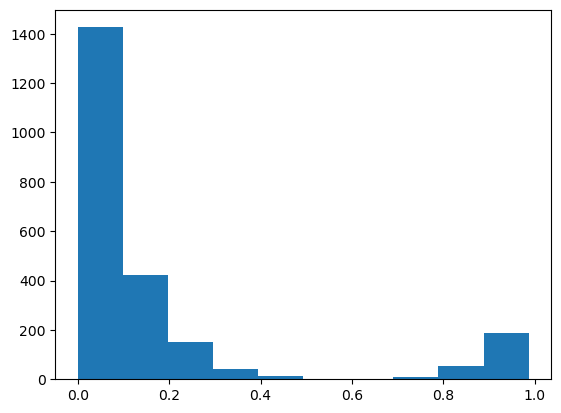

In [392]:
plt.hist(y_train_prediction)

(array([112.,  46.,  30.,  21.,  13.,  12.,   7.,   7.,   5.,   4.]),
 array([9.4219617e-04, 9.6472807e-02, 1.9200341e-01, 2.8753403e-01,
        3.8306463e-01, 4.7859523e-01, 5.7412583e-01, 6.6965646e-01,
        7.6518708e-01, 8.6071765e-01, 9.5624828e-01], dtype=float32),
 <BarContainer object of 10 artists>)

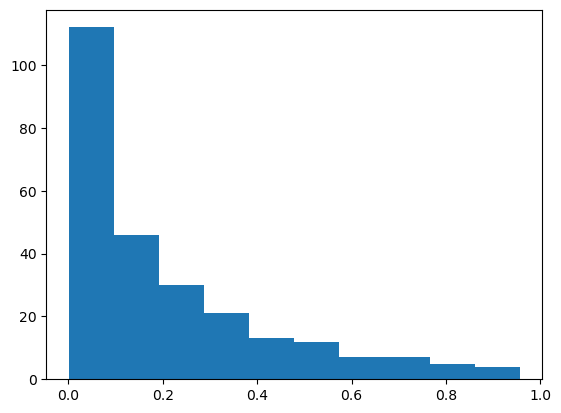

In [393]:
plt.hist(predictions)

In [394]:
metricas_modelo(y_train, y_train_prediction)

 brier: 1.37,
 confusion_m: 
[[2052    4]
 [   0  250]],
 acc_neg: 99.81,
 acc_pos: 100.0,
 accuracy: 99.83


In [395]:
metricas_modelo(y_test, predictions)

 brier: 15.77,
 confusion_m: 
[[200  29]
 [ 25   3]],
 acc_neg: 87.34,
 acc_pos: 10.71,
 accuracy: 78.99


In [342]:
metricas_modelo(y_test, np.repeat(0, len(y_test)))

 brier: 10.89,
 confusion_m: 
[[229   0]
 [ 28   0]],
 acc_neg: 100.0,
 acc_pos: 0.0,
 accuracy: 89.11


In [290]:
# Create and train XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="logloss")
xgb_model.fit(encoded_train, y_train)

# Predict and evaluate
predictions = xgb_model.predict_proba(encoded_test)[:,-1]
brier_score = brier_score_loss(y_test, predictions)
print(f"Training Brier Score: {brier_score}")
# Training Brier Score: 0.11279726129791122
# Training Brier Score: 0.11714360481200606
# Training Brier Score: 0.11777625155561622

Training Brier Score: 0.11207503183436726


In [167]:
predictions

array([0.20261128, 0.01139878, 0.03176539, 0.00174099, 0.03037201,
       0.11268315, 0.0705601 , 0.01711762, 0.00775052, 0.00807216,
       0.10227863, 0.0153977 , 0.07191005, 0.01977401, 0.3084631 ,
       0.00619547, 0.10055505, 0.06730863, 0.88475347, 0.04632831,
       0.03381374, 0.18474172, 0.04538668, 0.00849536, 0.17397577,
       0.05084885, 0.00346983, 0.00200994, 0.01535886, 0.02459586,
       0.05409465, 0.02091833, 0.09182653, 0.05586762, 0.0429269 ,
       0.04708069, 0.10406672, 0.04846288, 0.3756952 , 0.11448886,
       0.03986258, 0.00359359, 0.03047883, 0.09930124, 0.01145795,
       0.19437358, 0.00876731, 0.17942841, 0.0133851 , 0.28511563,
       0.00901161, 0.04791351, 0.01136111, 0.02722641, 0.00798612,
       0.07275734, 0.02403409, 0.01769442, 0.01327464, 0.00485444,
       0.00527194, 0.01229402, 0.6199905 , 0.03574907, 0.00404248,
       0.04562401, 0.07563102, 0.00372288, 0.06702212, 0.01861775,
       0.1906434 , 0.03473552, 0.07217296, 0.07647882, 0.03717